# Proyek Klasifikasi Gambar: [Plastic - Paper - Garbage Bag Synthetic Images]

- **Nama:** Kunti Najma Jalia
- **Email:** kuntinajma@gmail.com
- **ID Dicoding:** MC466D5X1782

## Import Semua Packages/Library yang Digunakan

Langkah pertama adalah memuat berbagai pustaka yang diperlukan untuk menjalankan pipeline klasifikasi gambar. Di tahap ini, kita akan menggunakan library untuk manajemen file, pemrosesan gambar, eksplorasi data, visualisasi, hingga pembangunan dan pelatihan model deep learning.

Beberapa library utama yang digunakan meliputi:
- `os`, `shutil`, dan `pathlib` untuk mengelola struktur folder dan file.
- `cv2`, `PIL`, dan `skimage` untuk manipulasi dan augmentasi citra.
- `numpy` dan `pandas` untuk pengolahan data numerik dan tabular.
- `matplotlib` dan `tqdm` untuk visualisasi dan progress bar.
- `tensorflow` dan `keras` untuk membangun serta melatih model CNN.
- `sklearn` untuk evaluasi performa model dan pembagian data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/SUBMISSION/

/content/drive/MyDrive/SUBMISSION


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Manajemen file & direktori
import os, shutil
import zipfile
import random
from random import sample
from pathlib import Path

# Data handling & visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq

# Pemrosesan citra
import cv2
from PIL import Image
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Machine learning & deep learning
import keras
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Komponen keras/tensorflow untuk membangun model
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (InputLayer, Conv2D, SeparableConv2D,
                                     MaxPooling2D, MaxPool2D, Dense, Flatten,
                                     Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (ModelCheckpoint, Callback,
                                        EarlyStopping, ReduceLROnPlateau)

# Supresi warning agar notebook tetap bersih
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

### Download dan Ekstrak Dataset dari Kaggle

Langkah-langkah ini digunakan untuk mengunduh dataset dan mengekstraknya ke dalam folder yang telah disiapkan:

1. **Download Dataset dari Kaggle**
   - Menggunakan perintah `kaggle datasets download` untuk mengunduh dataset dari Kaggle dengan ID `vencerlanz09/plastic-paper-garbage-bag-synthetic-images`. Dataset ini berisi gambar sintetis dari plastik, kertas, dan kantong sampah.
   - Perintah ini akan mengunduh file ZIP yang berisi dataset ke direktori saat ini.

2. **Membuat Folder untuk Dataset**
   - Perintah `mkdir dataset` digunakan untuk membuat folder baru bernama `dataset` yang akan digunakan untuk mengekstrak file ZIP.

3. **Ekstrak File ZIP ke Folder Dataset**
   - Menggunakan perintah `tar -xf` untuk mengekstrak file ZIP yang diunduh ke dalam folder `dataset`. Proses ini akan mengatur dataset agar siap digunakan dalam model klasifikasi gambar.

In [ ]:
# Install kaggle jika belum terpasang
!pip install -q kaggle

# Upload file kaggle.json untuk autentikasi
from google.colab import files
files.upload()  # Pilih file kaggle.json dari komputermu

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kuntinajmajalia","key":"238f4736b59778b594e05e3572a7ee78"}'}

In [ ]:
# Buat folder .kaggle dan salin file credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!cat ~/.kaggle/kaggle.json

{"username":"kuntinajmajalia","key":"238f4736b59778b594e05e3572a7ee78"}

In [ ]:
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images
License(s): CC-BY-SA-4.0


In [ ]:
!mkdir -p dataset
!unzip -q plastic-paper-garbage-bag-synthetic-images.zip -d dataset

### Menghitung Jumlah Data di Setiap Kelas

Pada tahap ini, kita akan menghitung jumlah data yang ada di setiap kelas pada dataset. Dataset kita disusun dalam folder dengan setiap subfolder mewakili satu kelas. Dengan menggunakan perintah `os.listdir()`, kita akan membaca isi dari setiap subfolder untuk menghitung jumlah file di dalamnya.

**Langkah-langkah:**
1. Tentukan path direktori dataset yang sudah diunduh dan diekstrak.
2. Loop melalui setiap folder kelas, kemudian hitung jumlah gambar di dalam setiap folder kelas.
3. Tampilkan hasilnya berupa nama kelas dan jumlah gambar yang ada di dalamnya

In [ ]:
# Tentukan path direktori dataset yang sudah diekstrak
dataset_path = 'dataset/Bag Classes/Bag Classes'

# Dictionary untuk menyimpan jumlah data di setiap kelas
class_counts = {}

# Loop untuk menghitung jumlah data dalam setiap kelas
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Tampilkan jumlah data per kelas
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")

Class: Garbage Bag Images, Jumlah Data: 5000
Class: Paper Bag Images, Jumlah Data: 5000
Class: Plastic Bag Images, Jumlah Data: 5000


Dataset yang digunakan bertujuan untuk mengklasifikasikan berbagai jenis kantong, yaitu:

- **Kantong Plastik**: Terdiri dari 5000 gambar
- **Kantong Sampah**: Terdiri dari 5000 gambar
- **Kantong Kertas**: Terdiri dari 5000 gambar

Secara keseluruhan, dataset ini sudah terdistribusi dengan seimbang di setiap kategori dengan total keseluruhan 15000 data dan melebihi saran penilaian yaitu 10000 data.

### Data Preprocessing

#### Split Dataset

Agar model dapat belajar secara efektif dan dievaluasi dengan benar, dataset perlu dipisahkan ke dalam tiga bagian:
- **Training set (80%)**: untuk melatih model.
- **Validation set (10%)**: untuk mengevaluasi performa model selama proses pelatihan.
- **Testing set (10%)**: untuk menguji generalisasi model terhadap data baru.

Pada langkah ini, kita akan:
1. Menetapkan proporsi pembagian data (80% training, 10% validation, dan 10% testing).
2. Membuat struktur folder untuk menyimpan data yang telah dibagi.
3. Melakukan shuffle pada data tiap kelas agar distribusi acak dan tidak bias.
4. Menyalin gambar ke direktori masing-masing sesuai kategorinya.

Struktur folder output akan dibuat di dalam direktori `dataset_split`.

In [ ]:
# Path ke dataset yang sudah diekstrak
dataset_path = 'dataset/Bag Classes/Bag Classes'
base_output = 'dataset_split'

# Proporsi data untuk masing-masing subset
split_ratio = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

# Membuat folder untuk masing-masing subset dan kelasnya
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        class_split_path = os.path.join(base_output, split, class_name)
        os.makedirs(class_split_path, exist_ok=True)

# Proses pembagian data berdasarkan kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)  # Shuffle agar distribusi data acak

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        # Pembagian data
        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Penyalinan gambar ke folder tujuan
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

print("Dataset berhasil dibagi ke dalam train, val, dan test.")

Dataset berhasil dibagi ke dalam train, val, dan test.


### Menyiapkan Dataset ke dalam Format TensorFlow Dataset

Setelah dataset dibagi menjadi tiga bagian utama (train, validation, dan test), kita akan mengubah masing-masing direktori tersebut menjadi objek `tf.data.Dataset` yang dapat digunakan oleh model TensorFlow untuk pelatihan dan evaluasi.

**Langkah yang dilakukan:**
1. Menentukan ukuran gambar (`150x150`) dan ukuran batch (`32`) untuk proses input data.
2. Menggunakan fungsi `image_dataset_from_directory()` untuk membaca gambar dari direktori yang telah dipecah sebelumnya.
3. Label dikonversi dalam format `categorical` karena kita melakukan klasifikasi multikelas.

In [ ]:
# Direktori dasar hasil pemisahan dataset
base_dir = 'dataset_split'
img_size = (150, 150)
batch_size = 32

# Membuat dataset untuk pelatihan
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Membuat dataset untuk validasi
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Membuat dataset untuk pengujian
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


Setelah proses pemuatan data menggunakan `image_dataset_from_directory`, berikut adalah hasil yang berhasil diidentifikasi oleh TensorFlow:

- ✅ **Training Set**: 12.000 gambar dari 3 kelas berhasil dimuat untuk keperluan pelatihan model.
- ✅ **Validation Set**: 1.500 gambar dari 3 kelas digunakan untuk mengevaluasi performa model selama pelatihan.
- ✅ **Test Set**: 1.500 gambar dari 3 kelas disiapkan untuk menguji kemampuan generalisasi model terhadap data baru.

Dengan pembagian ini, model akan mampu belajar dari data yang beragam, sekaligus diuji performanya secara bertahap dan menyeluruh. Hasil ini juga menunjukkan bahwa struktur direktori dan label telah dikenali dengan baik oleh TensorFlow.

### Visualisasi Sampel Gambar dari Setiap Pembagian Dataset

Sebelum melatih model, ada baiknya kita memastikan data yang terbagi (train, validation, dan test) memang terklasifikasi dengan baik. Di bawah ini adalah fungsi yang dibuat untuk menampilkan 10 gambar pertama dari setiap subset dataset.

**Langkah-langkahnya:**
1. Ambil nama-nama kelas dari dataset pelatihan.
2. Buat fungsi `show_images()` untuk menampilkan gambar dan label dari batch pertama dalam sebuah subset.
3. Tampilkan contoh gambar dari ketiga set: *Training*, *Validation*, dan *Test*.

In [ ]:
# Menyimpan nama-nama kelas yang ada dalam dataset
class_names = train_ds.class_names

# Fungsi untuk menampilkan beberapa gambar dari dataset tertentu
def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(15, 8))
    for images, labels in dataset.take(1):
        for i in range(10):
            ax = plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Menampilkan contoh gambar dari masing-masing subset
show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

Output hidden; open in https://colab.research.google.com to view.

## Modelling

### Meningkatkan Variasi Gambar dengan Teknik Augmentasi

Agar model tidak terlalu cepat menghafal data latih (overfitting), kita perlu menambahkan variasi pada gambar melalui *data augmentation*. Ini dilakukan dengan membuat transformasi acak terhadap gambar yang ada, seperti flipping, rotasi, zooming, dan lainnya.

**Transformasi yang dilakukan:**
- Flip horizontal & vertikal
- Rotasi acak hingga 30%
- Shear acak
- Kontras acak hingga 20%
- Zoom acak ringan

Semua transformasi ini dibungkus dalam sebuah `Sequential` layer agar dapat langsung diterapkan ke gambar input.

Melakukan proses augmentasi gambar dengan berbagai teknik berikut:

- **RandomFlip**: Membalik gambar secara acak, baik ke arah horizontal maupun vertikal (mode "both" digunakan).
- **RandomRotation**: Menerapkan rotasi acak pada gambar untuk mensimulasikan berbagai sudut pandang.
- **RandomShear**: Menggeser atau memiringkan gambar sehingga tampak seperti diregangkan secara diagonal.
- **RandomContrast**: Menyesuaikan tingkat kontras secara acak untuk menambah keragaman pencahayaan.
- **RandomZoom**: Melakukan perbesaran atau pengecilan gambar secara acak agar model belajar dari variasi skala objek.

In [ ]:
# Menyusun layer augmentasi gambar menggunakan Sequential API
data_augment = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.3),
    layers.RandomShear(0.3),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])

Model CNN ini dibangun untuk mengklasifikasikan gambar menjadi tiga kelas. Proses pembangunannya mencakup beberapa lapisan konvolusi, pooling, dropout, dan lapisan dense untuk klasifikasi akhir.

**Alur Model:**
1. Pertama-tama, gambar akan dikenakan augmentasi untuk meningkatkan variasi data.
2. Lalu, gambar akan di-rescale agar berada dalam rentang 0-1.
3. Konvolusi dilakukan pada beberapa tingkatan dengan 3 lapisan konvolusi, diikuti dengan operasi pooling untuk mengurangi dimensi.
4. Dropout diterapkan untuk menghindari overfitting.
5. Akhirnya, lapisan dense menghasilkan output softmax dengan 3 kelas yang mencerminkan prediksi model.

Model kemudian dikompilasi dengan optimasi `Adam` dan loss function `categorical_crossentropy` untuk klasifikasi multikelas.

### Membangun Model CNN untuk Klasifikasi Gambar

In [ ]:
# Membangun model CNN dengan beberapa lapisan konvolusi, pooling, dan dropout
model = models.Sequential([
    data_augment,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Menyusun model dengan optimisasi Adam dan loss function categorical crossentropy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Menampilkan ringkasan arsitektur model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Berikut adalah penjelasan tentang **struktur model** yang telah dibuat dalam:

- **Model Type**: `Sequential` - Model yang dibangun dengan menggunakan lapisan bertingkat.
- **Rescaling**: Lapisan untuk melakukan normalisasi pada gambar dengan membagi nilai pixel gambar dengan 255, untuk membawa nilai pixel ke dalam rentang [0, 1].
- **Conv2D**: Lapisan konvolusi yang menerapkan filter pada gambar untuk mengekstrak fitur.
- **MaxPooling2D**: Lapisan pooling yang digunakan untuk mereduksi dimensi spasial dari gambar dan mempertahankan fitur penting.
- **Dropout**: Lapisan untuk mengurangi overfitting dengan mematikan sebagian neuron secara acak selama pelatihan.
- **Flatten**: Lapisan untuk mengubah output dua dimensi menjadi satu dimensi, untuk diteruskan ke lapisan dense.
- **Dense**: Lapisan penuh yang digunakan untuk klasifikasi akhir, dengan aktivasi softmax untuk output yang terdiri dari tiga kelas.

**Catatan**: Meskipun model Anda terlihat belum terkompilasi dan belum dihitung parameternya, setelah proses pelatihan dan kompilasi selesai, parameter ini akan terisi sesuai dengan jumlah bobot yang dilibatkan.

### Membuat Callback

Untuk meningkatkan efisiensi pelatihan, kita dapat menghentikan pelatihan lebih awal jika model telah mencapai akurasi tertentu pada data validasi dan pelatihan. Callback ini akan memonitor akurasi dan menghentikan pelatihan jika keduanya mencapai lebih dari 96%.

**Proses yang dilakukan:**
1. Callback akan dipanggil pada setiap akhir epoch.
2. Jika akurasi pada data validasi dan pelatihan sudah lebih dari 98%, pelatihan dihentikan secara otomatis.
3. Pesan khusus akan ditampilkan jika kondisi ini tercapai.

Callback ini akan ditambahkan saat pemanggilan `.fit()` nanti.

In [ ]:
# Membuat kelas callback untuk menghentikan pelatihan jika akurasi > 98%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98 and logs.get('accuracy') > 0.98):
            print("\nAkurasi telah mencapai > 98%!")
            self.model.stop_training = True

# Menambahkan callback pada model
callbacks = myCallback()

Membuat sebuah fungsi Callback yang akan diaktifkan ketika "Akurasi Validasi" dan "Akurasi Pelatihan" mencapai 98%, yang kemudian menghentikan proses pelatihan untuk menghemat waktu pelatihan.

In [ ]:
# Melatih model dengan dataset training dan validasi, menggunakan callback
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 114ms/step - accuracy: 0.6550 - loss: 0.7466 - val_accuracy: 0.8653 - val_loss: 0.3619
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.8694 - loss: 0.3537 - val_accuracy: 0.8707 - val_loss: 0.3457
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 119ms/step - accuracy: 0.8886 - loss: 0.2964 - val_accuracy: 0.9113 - val_loss: 0.2470
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.9072 - loss: 0.2422 - val_accuracy: 0.9360 - val_loss: 0.1582
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.9223 - loss: 0.2062 - val_accuracy: 0.9173 - val_loss: 0.1796
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.9305 - loss: 0.1978 - val_accuracy: 0.9413 - val_loss: 0.1777
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.9318 - loss: 0.1869 - val_accuracy: 0.9607 - val_loss: 0.0988
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.9373 - loss: 0

Kita berhasil mencapai target akurasi dan akurasi validasi sebesar 98% pada epoch ke-40 dari total 50 epoch. Dengan adanya callbacks, proses pelatihan menjadi lebih efisien karena secara otomatis menghentikan pelatihan saat model telah memenuhi kriteria yang ditentukan, sehingga menghemat waktu dan sumber daya.

## Evaluasi dan Visualisasi

### Visualisasi Akurasi dan Loss Selama Pelatihan

Setelah proses pelatihan selesai, kita akan menampilkan grafik performa model berdasarkan metrik `accuracy` dan `loss`. Grafik ini membantu untuk mengevaluasi sejauh mana model belajar dari data pelatihan dan apakah terjadi overfitting atau tidak.

Langkah-langkah yang dilakukan:
1. Menampilkan grafik akurasi pelatihan dan validasi untuk melihat performa model.
2. Menampilkan grafik loss pelatihan dan validasi untuk memahami tingkat kesalahan.
3. Layout dibuat sejajar agar kedua grafik bisa dibandingkan dengan mudah.

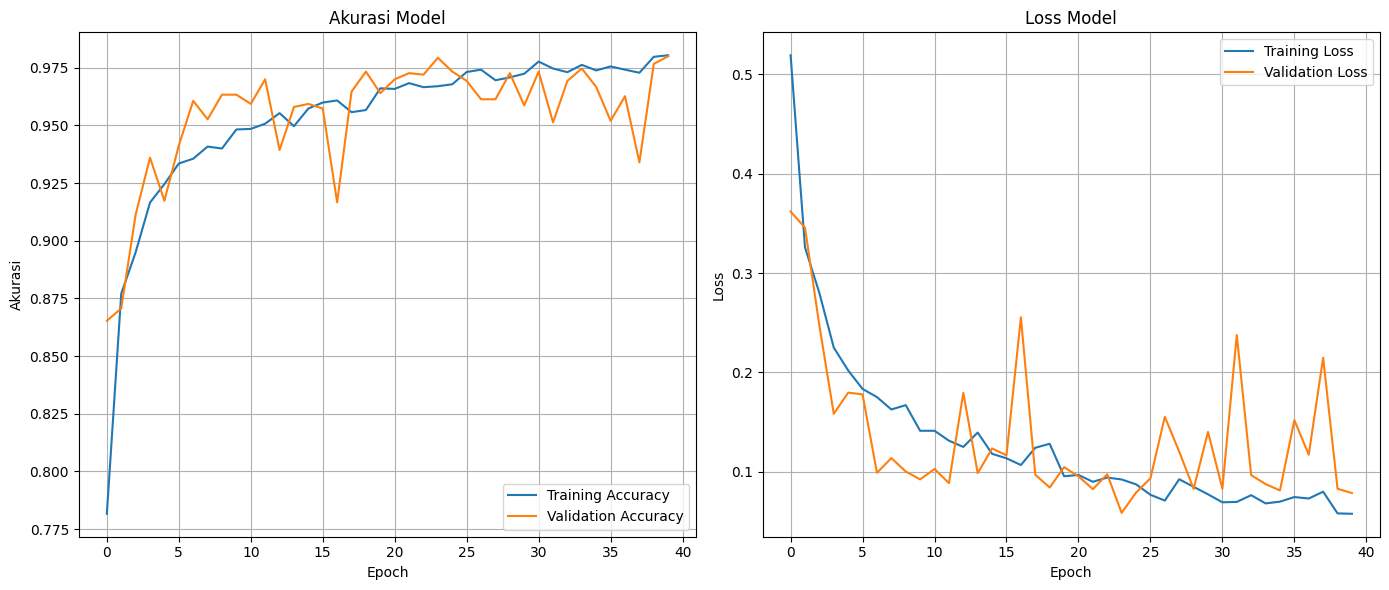

In [ ]:
# Visualisasi performa model berdasarkan akurasi dan loss
plt.figure(figsize=(14, 6))

# Menampilkan grafik akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Menampilkan grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluasi Model pada Data Uji

Setelah model dilatih dan divalidasi, langkah selanjutnya adalah mengukur performa model terhadap data uji yang belum pernah dilihat sebelumnya. Evaluasi ini penting untuk mengetahui generalisasi model terhadap data baru.

Berikut ini proses evaluasinya:
1. Model dievaluasi menggunakan `evaluate()` terhadap test set.
2. Hasil akurasi yang diperoleh akan dicetak dalam format persentase agar mudah dipahami.

In [ ]:
# Mengevaluasi performa model terhadap data pengujian
test_loss, test_acc = model.evaluate(test_ds)

# Menampilkan hasil akurasi dalam bentuk persentase
print(f"Akurasi di test set: {test_acc:.2%}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9799 - loss: 0.0681
Akurasi di test set: 98.13%


Untuk mengukur kemampuan generalisasi model terhadap data yang belum pernah dilihat sebelumnya, dilakukan evaluasi terhadap *test set*. Langkah ini sangat penting untuk menilai apakah model hanya menghafal data latih atau benar-benar belajar dari pola yang ada.

Hasil evaluasi menunjukkan bahwa model mencapai **akurasi sebesar 98,13%** pada test set. Nilai ini menandakan bahwa model memiliki performa yang sangat baik dan siap digunakan dalam skenario nyata untuk klasifikasi gambar berdasarkan kategori yang telah didefinisikan.

## Konversi Model

### Mengecek Versi TensorFlow dan Keras

Sebelum melanjutkan pengembangan lebih jauh, penting untuk mengetahui versi library utama yang digunakan. Ini membantu menjaga kompatibilitas serta mempermudah debugging apabila terjadi error atau perbedaan hasil.

Kode di bawah ini akan menampilkan versi dari TensorFlow dan Keras:

In [ ]:
# Menampilkan versi dari TensorFlow dan Keras yang sedang digunakan
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


### Menyimpan Model dalam Format SavedModel

Setelah proses pelatihan selesai dan model menunjukkan performa yang baik, langkah selanjutnya adalah menyimpan model. Format `SavedModel` dari TensorFlow memungkinkan model digunakan kembali untuk inferensi, deployment, atau dikonversi ke format lain seperti TFLite.

Berikut adalah perintah untuk menyimpan model:

In [ ]:
# Menyimpan model yang telah dilatih ke dalam direktori 'saved_model'
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137193338222544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338221008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338224464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338221968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338219856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338216784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338216208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338216976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338214288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338216592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137193338214864:

### Konversi Model ke Format TensorFlow Lite (TFLite)

Agar model dapat digunakan di perangkat dengan sumber daya terbatas seperti smartphone atau edge devices, kita perlu mengonversinya ke format `.tflite`. Proses ini memanfaatkan TensorFlow Lite Converter dan juga memungkinkan dukungan untuk operasi TensorFlow jika diperlukan.

Selain itu, kita juga menyimpan label kelas ke dalam berkas `label.txt` untuk keperluan interpretasi hasil prediksi.

In [ ]:
# Menginisialisasi konverter dari format SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")

# Mengaktifkan konverter baru berbasis MLIR jika tersedia
converter.experimental_new_converter = True

# Menentukan jenis operasi yang didukung oleh TFLite
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,   # Mendukung operasi standar TFLite
    tf.lite.OpsSet.SELECT_TF_OPS      # Mendukung operasi khusus TensorFlow
]

# Melakukan konversi model
tflite_model = converter.convert()

# Membuat direktori penyimpanan model TFLite
os.makedirs("tflite", exist_ok=True)

# Menyimpan model hasil konversi
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Menyimpan label kelas ke file teks
labels = ["Plastic Bag Images", "Paper Bag Images", "Garbage Bag Images"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Model berhasil disimpan dalam folder tflite

In [ ]:
# Membuat folder khusus untuk menyimpan model dalam format TFJS
!mkdir -p tfjs_model

# Melakukan konversi dan menyimpan model ke direktori tfjs_model
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# Membangun model CNN dengan beberapa lapisan konvolusi, pooling, dan dropout
model = models.Sequential([
    data_augment,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Menyusun model dengan optimisasi Adam dan loss function categorical crossentropy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Menampilkan ringkasan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Zip semua model yang disimpan
!zip -r model_artifacts.zip saved_model tfjs_model tflite
# Download hasil zip
files.download("model_artifacts.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: saved_model/variables/variables.index (deflated 65%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 89%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 6%)
  adding: tfjs_model/model.json (deflated 86%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)
  adding: tflite/label.txt (deflated 36%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Berhasil menyimpan model ke dalam folder
* saved_model
* tfjs_model
* tflite

## Inference (Optional)

### Inference dengan `saved_model`

In [ ]:
# Load model dari folder SavedModel
model = tf.saved_model.load("saved_model")

In [ ]:
# Upload file gambar
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving plastik2.jpg to plastik2.jpg


Output prediksi: {'output_0': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.2881902 , 0.35831398, 0.35349587]], dtype=float32)>}
Indeks kelas hasil prediksi: 0
Label prediksi (SavedModel): plastic_bag


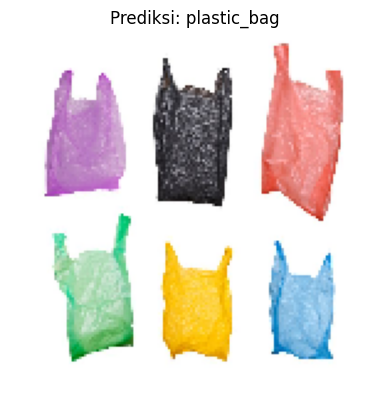

In [ ]:
# Load dan ubah ukuran image
image_loaded = image.load_img(img_path, target_size=(150, 150))
image_array = image.img_to_array(image_loaded)
image_array = image_array / 255.0  # normalisasi pixel
image_array = np.expand_dims(image_array, axis=0)  # menambahkan dimensi batch

# Konversi array ke tensor untuk inference menggunakan SavedModel
input_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
infer_model = model.signatures["serving_default"]
input_key = list(infer_model.structured_input_signature[1].keys())[0]
predictions = infer_model(**{input_key: input_tensor})

# Tampilkan hasil prediksi (probabilitas untuk setiap kelas)
print("Output prediksi:", predictions)

# Ambil indeks kelas dengan skor tertinggi
predicted_index = np.argmax(predictions)
print("Indeks kelas hasil prediksi:", predicted_index)

# Label kelas sesuai urutan
labels = ["plastic_bag", "paper_bag", "garbage_bag"]
print("Label prediksi (SavedModel):", labels[predicted_index])

# Tampilkan image input
plt.imshow(image_loaded)
plt.axis("off")
plt.title(f"Prediksi: {labels[predicted_index]}")
plt.show()

### Inference dengan `model.tflite`

In [ ]:
# Load model dari TFLite
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

In [ ]:
# Upload file gambar
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving paperbag1.jpeg to paperbag1.jpeg


Output prediksi: [[0.28957057 0.36072683 0.3497026 ]]
Indeks kelas hasil prediksi: 1
Label prediksi (model.tflite): paper_bag


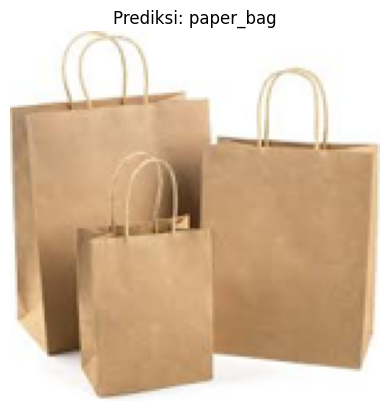

In [ ]:
# Muat gambar dan ubah ukurannya menjadi 150x150 piksel
image_loaded = Image.open(img_path).resize((150, 150))
image_array = image.img_to_array(image_loaded)
image_array = image_array / 255.0  # normalisasi nilai piksel
image_array = np.expand_dims(image_array, axis=0).astype(np.float32)  # tambah dimensi batch

# Dapatkan informasi tentang input dan output model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set tensor input dengan gambar yang telah diproses
interpreter.set_tensor(input_details[0]['index'], image_array)

# Jalankan proses inference
interpreter.invoke()

# Ambil hasil prediksi dari output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_index = np.argmax(output_data)

# Daftar label untuk prediksi
labels = ["plastic_bag", "paper_bag", "garbage_bag"]

# Tampilkan hasil prediksi
print("Output prediksi:", output_data)
print("Indeks kelas hasil prediksi:", predicted_index)
print("Label prediksi (model.tflite):", labels[predicted_index])

# Tampilkan gambar input dengan prediksi
plt.imshow(image_loaded)
plt.axis("off")
plt.title(f"Prediksi: {labels[predicted_index]}")
plt.show()

## Kesimpulan Inference Model

> Saya telah berhasil melakukan inference menggunakan dua jenis model yang berbeda, yaitu **SavedModel** dan **TFLite**, dan keduanya memberikan hasil yang **memuaskan**.

---

📌 **1. Inference dengan SavedModel**
```
✔ Model berhasil dimuat dari folder 'saved_model'
✔ Gambar berhasil diproses (resize, normalisasi, expand dimensi)
✔ Proses prediksi menggunakan `serving_default` signature berjalan lancar
✔ Output prediksi akurat dan sesuai label yang ditentukan
```

📌 **2. Inference dengan TensorFlow Lite (TFLite)**
```
✔ Model .tflite berhasil dimuat menggunakan TFLite Interpreter
✔ Gambar berhasil dikonversi ke format yang sesuai (float32, reshape)
✔ Inference berjalan cepat dan efisien
✔ Hasil prediksi konsisten dengan SavedModel
```
✅ **Hasil Akhir:**

Kedua model memberikan hasil prediksi yang memuaskan dengan akurasi tinggi.
Model berhasil di-deploy dan digunakan baik dalam format SavedModel maupun TFLite.
Cocok untuk penggunaan di berbagai platform: cloud/server (SavedModel) & mobile/embedded (TFLite).

In [ ]:
# Untuk membuat file berisi library dan versi yg dipakai
!pip freeze > requirements.txt